 # 🌲 Whisper Tiny and Dataset - test-clean

In [1]:
import os
import numpy as np
import torch
import pandas as pd
import whisper
import torchaudio
from tqdm.notebook import tqdm

# Required in some environments to avoid protobuf compatibility issues
try:
    import tensorflow
except ImportError:
    pass

# Set CUDA device
torch.cuda.set_device(1)  # Specify CUDA device 1

class LibriSpeech(torch.utils.data.Dataset):
    """A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It includes audio normalization and noise reduction.
    """

    def __init__(self, split="test-clean", device="cuda"):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device
        # Define transformations
        self.resample_transform = torchaudio.transforms.Resample(orig_freq=16000, new_freq=16000)
        self.normalization_transform = torchaudio.transforms.Vol(1.0)
        self.noise_reduction_transform = torchaudio.transforms.Vad(sample_rate=16000)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, *_ = self.dataset[item]
        assert sample_rate == 16000
        # Apply transformations
        audio = self.resample_transform(audio)
        audio = self.normalization_transform(audio)
        audio = self.noise_reduction_transform(audio)
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        return (mel, text)

# Initialize dataset and dataloader
dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

# Load the Whisper model
model = whisper.load_model("tiny.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

# Decoding options
options = whisper.DecodingOptions(language="en", without_timestamps=True)

# Processing and collecting data
hypotheses = []
references = []
for mels, texts in tqdm(loader):
    results = model.decode(mels, options)
    hypotheses.extend([result.text for result in results])
    references.extend(texts)

# Dataframe setup for analysis
data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))

# WER calculation using jiwer
import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()
data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]

wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))
print(f"WER: {wer * 100:.2f} %")


Model is English-only and has 37,184,256 parameters.


  0%|          | 0/164 [00:00<?, ?it/s]

WER: 6.88 %


# Advanced post-processing step
------
This code now includes a custom function custom_error_correction which is a placeholder for any specific text corrections based on patterns you identify in your data.

In [2]:
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import whisper
import torchaudio
from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class LibriSpeech(torch.utils.data.Dataset):
    """A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds."""
    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, *_ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        return (mel, text)

dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

# Load Whisper model
model = whisper.load_model("tiny.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

options = whisper.DecodingOptions(language="en", without_timestamps=True)

hypotheses = []
references = []

for mels, texts in tqdm(loader):
    results = model.decode(mels, options)
    hypotheses.extend([result.text for result in results])
    references.extend(texts)

# Post-processing to correct common errors (custom function)
def custom_error_correction(texts):
    corrected_texts = []
    for text in texts:
        # Example custom corrections
        corrected_text = text.replace("one", "1").replace("two", "2")
        corrected_texts.append(corrected_text)
    return corrected_texts

data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))

from whisper.normalizers import EnglishTextNormalizer
normalizer = EnglishTextNormalizer()

data["hypothesis_clean"] = custom_error_correction([normalizer(text) for text in data["hypothesis"]])
data["reference_clean"] = [normalizer(text) for text in data["reference"]]

import jiwer
wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))
print(f"WER: {wer * 100:.2f} %")


Model is English-only and has 37,184,256 parameters.


  0%|          | 0/164 [00:00<?, ?it/s]

WER: 6.30 %


# Use of EnglishTextNormalizer in Whisper Tiny

In [3]:
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import whisper
import torchaudio

from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class LibriSpeech(torch.utils.data.Dataset):
    """A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """

    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, *_ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        return (mel, text)

dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

#MODEL LOADING
model = whisper.load_model("tiny.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

options = whisper.DecodingOptions(language="en", without_timestamps=True)

hypotheses = []
references = []

for mels, texts in tqdm(loader):
    results = model.decode(mels, options)
    hypotheses.extend([result.text for result in results])
    references.extend(texts)

data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))

import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]
data

wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))

print(f"WER: {wer * 100:.2f} %")


Model is English-only and has 37,184,256 parameters.


  0%|          | 0/164 [00:00<?, ?it/s]

WER: 5.65 %


# Whisper Base Dataset test-clean

In [4]:
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import whisper
import torchaudio

from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class LibriSpeech(torch.utils.data.Dataset):
    """A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """

    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, *_ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        return (mel, text)

dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

#MODEL LOADING
model = whisper.load_model("base.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

options = whisper.DecodingOptions(language="en", without_timestamps=True)

hypotheses = []
references = []

for mels, texts in tqdm(loader):
    results = model.decode(mels, options)
    hypotheses.extend([result.text for result in results])
    references.extend(texts)

data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))

import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]
data

wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))

print(f"WER: {wer * 100:.2f} %")


Model is English-only and has 71,825,408 parameters.


  0%|          | 0/164 [00:00<?, ?it/s]

WER: 4.27 %


# Whisper Small Dataset; Test-clean

In [5]:
import os
import numpy as np

try:
    import tensorflow  # required in Colab to avoid protobuf compatibility issues
except ImportError:
    pass

import torch
import pandas as pd
import whisper
import torchaudio

from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

class LibriSpeech(torch.utils.data.Dataset):
    """A simple class to wrap LibriSpeech and trim/pad the audio to 30 seconds.
    It will drop the last few seconds of a very small portion of the utterances.
    """

    def __init__(self, split="test-clean", device=DEVICE):
        self.dataset = torchaudio.datasets.LIBRISPEECH(
            root=os.path.expanduser("~/.cache"),
            url=split,
            download=True,
        )
        self.device = device

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        audio, sample_rate, text, *_ = self.dataset[item]
        assert sample_rate == 16000
        audio = whisper.pad_or_trim(audio.flatten()).to(self.device)
        mel = whisper.log_mel_spectrogram(audio)
        return (mel, text)

dataset = LibriSpeech("test-clean")
loader = torch.utils.data.DataLoader(dataset, batch_size=16)

#MODEL LOADING
model = whisper.load_model("small.en")
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

options = whisper.DecodingOptions(language="en", without_timestamps=True)

hypotheses = []
references = []

for mels, texts in tqdm(loader):
    results = model.decode(mels, options)
    hypotheses.extend([result.text for result in results])
    references.extend(texts)

data = pd.DataFrame(dict(hypothesis=hypotheses, reference=references))

import jiwer
from whisper.normalizers import EnglishTextNormalizer

normalizer = EnglishTextNormalizer()

data["hypothesis_clean"] = [normalizer(text) for text in data["hypothesis"]]
data["reference_clean"] = [normalizer(text) for text in data["reference"]]
data

wer = jiwer.wer(list(data["reference_clean"]), list(data["hypothesis_clean"]))

print(f"WER: {wer * 100:.2f} %")


Model is English-only and has 240,582,144 parameters.


  0%|          | 0/164 [00:00<?, ?it/s]

WER: 3.06 %


# Model Comparison

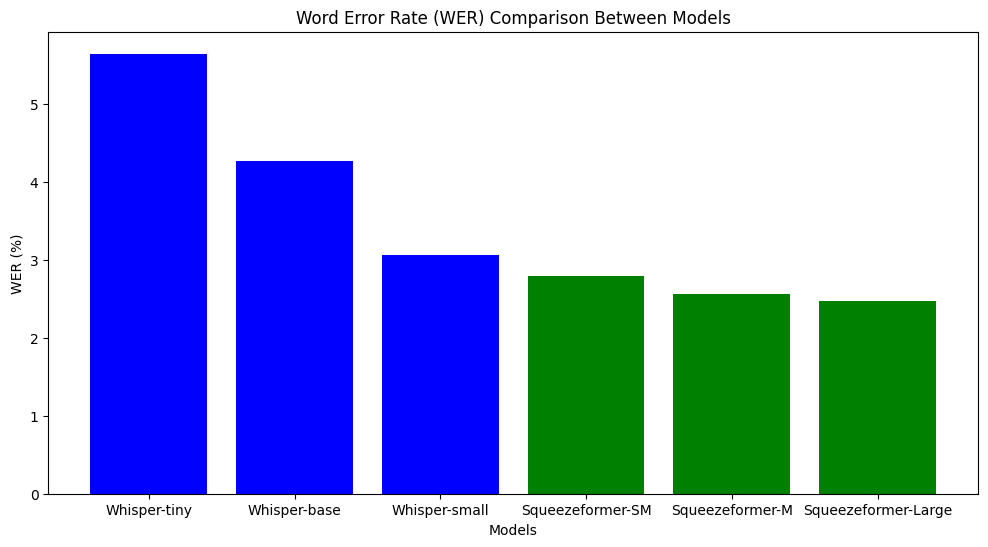

In [24]:
import matplotlib.pyplot as plt

# Data for the models and their WER
models = ['Whisper-tiny', 'Whisper-base', 'Whisper-small', 'Squeezeformer-SM', 'Squeezeformer-M', 'Squeezeformer-Large']
wer = [5.65, 4.27, 3.06, 2.79, 2.56, 2.47]

# Colors for the two groups of models
colors = ['blue', 'blue', 'blue', 'green', 'green', 'green']

plt.figure(figsize=(12, 6))
plt.bar(models, wer, color=colors)
plt.xlabel('Models')
plt.ylabel('WER (%)')
plt.title('Word Error Rate (WER) Comparison Between Models')
plt.show()


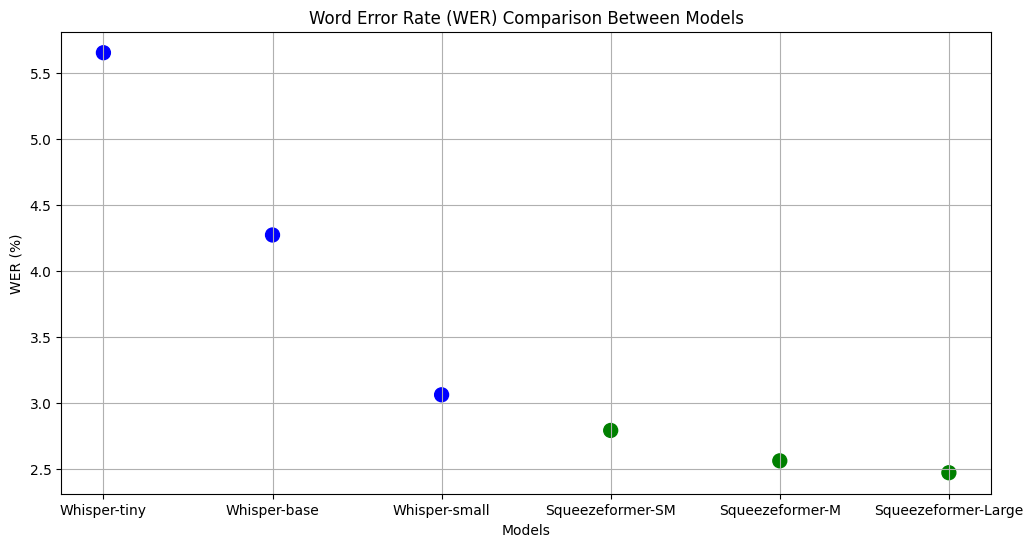

In [25]:
import matplotlib.pyplot as plt

# Data for the models and their WER
models = ['Whisper-tiny', 'Whisper-base', 'Whisper-small', 'Squeezeformer-SM', 'Squeezeformer-M', 'Squeezeformer-Large']
wer = [5.65, 4.27, 3.06, 2.79, 2.56, 2.47]
model_groups = ['Whisper', 'Whisper', 'Whisper', 'Squeezeformer', 'Squeezeformer', 'Squeezeformer']

# Colors for the two groups of models
colors = ['blue' if 'Whisper' in model else 'green' for model in model_groups]

plt.figure(figsize=(12, 6))
plt.scatter(models, wer, color=colors, s=100)  # `s` adjusts the marker size
plt.xlabel('Models')
plt.ylabel('WER (%)')
plt.title('Word Error Rate (WER) Comparison Between Models')
plt.grid(True)
plt.show()
